## Import & Process Image

In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Pipeline with Sampleset

In [11]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [12]:
def import_dataset(img_path, data_path):
    img_url = sorted(glob.glob(img_path+"/*.jpg"))
    csv_names = [i for i in glob.glob(data_path+'/*.csv')]
    df = pd.concat([pd.read_csv(f) for f in csv_names]).sort_values('name').reset_index(drop=True)
    df['image'] = img_url
    return df

def clean_dataset(df):
    dataset = df.copy()
    dataset = dataset[['meta.clinical.diagnosis', 'image']]
    dataset = dataset[dataset['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
    dataset.columns = ['diagnosis', 'image']
    dataset['diagnosis'] = (dataset['diagnosis'] == 'melanoma').astype(int)
    return dataset

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set

In [70]:
# Importing and creating test set. Returns X & y.
test_df = import_dataset('img_sample/img_test','data_sample/data_test')
test_df_cleaned = clean_dataset(test_df)
X_test, y_test = create_X_y(test_df_cleaned)

#### Creating Train Set

In [102]:
# Train Set
path = "img_sample/img_train"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

negative_csv =[i for i in glob.glob('data_sample/data_train/0/*.csv')]
positive_csv =[i for i in glob.glob('data_sample/data_train/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [103]:
# Train Set
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [20]:
## Create X and y for Train set. You only need to run this once!
# y = np.asarray(lbl_img_cl['diagnosis'])
# X = []
# for i in fileimages:
#     image = load_and_preprocess_image(i)
#     X.append(np.asarray(image))
# X = np.asarray(X)

#### Saving converted images to numpy file

In [105]:
# np.save('img_sample/test100x100.npy', X)
# np.save('img_sample/test_diagnosis.npy', y)

In [71]:
X = np.load('img_sample/test100x100.npy')
y = np.load('img_sample/test_diagnosis.npy')

In [72]:
# Train/test split for Train Set
X_train, X_val, y_train, y_val = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)

#### Train Model

In [73]:
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers[:-2]: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Conv2D(512, (5, 5), activation = 'relu', padding = 'same'))
new_model.add(MaxPooling2D(2,2))
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

In [74]:
opt = keras.optimizers.SGD(learning_rate=0.01)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [75]:
history = new_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
25/25 [==============================] - 18s 724ms/step - loss: 0.6464 - accuracy: 0.6830 - recall_7: 0.6775 - val_loss: 0.9029 - val_accuracy: 0.4100 - val_recall_7: 0.7922
Epoch 2/10
25/25 [==============================] - 18s 736ms/step - loss: 0.5203 - accuracy: 0.7268 - recall_7: 0.7325 - val_loss: 0.6927 - val_accuracy: 0.6067 - val_recall_7: 0.5195
Epoch 3/10
25/25 [==============================] - 18s 721ms/step - loss: 0.4275 - accuracy: 0.8108 - recall_7: 0.8000 - val_loss: 0.5951 - val_accuracy: 0.7233 - val_recall_7: 0.2727
Epoch 4/10
25/25 [==============================] - 18s 709ms/step - loss: 0.4157 - accuracy: 0.8221 - recall_7: 0.8200 - val_loss: 0.8777 - val_accuracy: 0.5200 - val_recall_7: 0.7273
Epoch 5/10
25/25 [==============================] - 18s 707ms/step - loss: 0.4214 - accuracy: 0.8233 - recall_7: 0.8250 - val_loss: 0.6909 - val_accuracy: 0.6500 - val_recall_7: 0.4675
Epoch 6/10
25/25 [==============================] - 18s 715ms/step - loss: 

In [14]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

In [15]:
# opt = keras.optimizers.SGD(learning_rate=0.01)
# model.compile(optimizer=opt,
#               loss='binary_crossentropy',
#               metrics=['accuracy',tf.keras.metrics.Recall()])

In [16]:
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
25/25 [==============================] - 4s 142ms/step - loss: 0.6941 - accuracy: 0.4975 - recall_1: 0.9050 - val_loss: 0.7133 - val_accuracy: 0.2567 - val_recall_1: 1.0000
Epoch 2/20
25/25 [==============================] - 3s 117ms/step - loss: 0.6910 - accuracy: 0.5150 - recall_1: 0.9075 - val_loss: 0.7186 - val_accuracy: 0.2567 - val_recall_1: 1.0000
Epoch 3/20
25/25 [==============================] - 3s 116ms/step - loss: 0.6899 - accuracy: 0.5113 - recall_1: 0.9325 - val_loss: 0.7065 - val_accuracy: 0.3000 - val_recall_1: 0.8831
Epoch 4/20
25/25 [==============================] - 3s 117ms/step - loss: 0.6863 - accuracy: 0.5602 - recall_1: 0.7850 - val_loss: 0.7286 - val_accuracy: 0.2567 - val_recall_1: 0.9870
Epoch 5/20
25/25 [==============================] - 3s 113ms/step - loss: 0.6839 - accuracy: 0.5551 - recall_1: 0.8500 - val_loss: 0.6967 - val_accuracy: 0.4733 - val_recall_1: 0.4156
Epoch 6/20
25/25 [==============================] - 3s 115ms/step - loss: 0.6834

In [76]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_recall(history, recall):
    plt.plot(history.history[recall])
    plt.plot(history.history['val_'+recall])
    plt.title('model recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

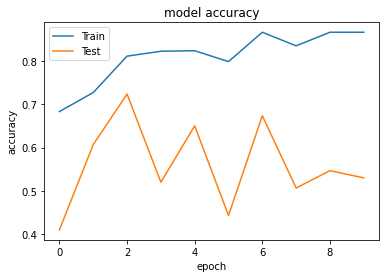

In [77]:
plot_accuracy(history)

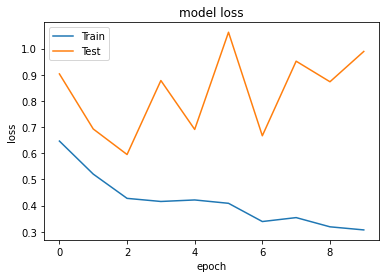

In [78]:
plot_loss(history)

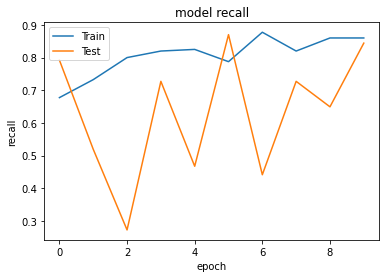

In [82]:
plot_recall(history, 'recall_7')

In [81]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_7', 'val_loss', 'val_accuracy', 'val_recall_7'])

## Evalaution

In [83]:
# Validation Set
val_loss, val_acc, val_recall = new_model.evaluate(X_val, y_val, verbose=0)
print('Val  set accuracy {:5.2f}%'.format(100*val_acc))
print('Val  set recall   {:5.2f}%'.format(100*val_recall))

# Test Set
test_loss, test_acc, test_recall = new_model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))
print('Test set recall   {:5.2f}%'.format(100*test_recall))


Val  set accuracy 77.50%
Val  set recall   91.00%
Test set accuracy 53.00%
Test set recall   84.42%


In [84]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.3f}'.format(tp/(tp+fn)))
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.3f}'.format(roc_auc_score(y_test, y_pred)))

In [144]:
threshold = 0.3

In [145]:
# Validation Set
result = (new_model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[98  2]
 [53 47]]
Recall:    0.980
Precision: 0.649
Accuracy:  0.725
ROC AUC:   0.725


In [146]:
# Test Set
result = (new_model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 74   3]
 [189  34]]
Recall:    0.961
Precision: 0.281
Accuracy:  0.360
ROC AUC:   0.557


## ROC AUC Curve

In [102]:
y_val_pred_keras = new_model.predict(X_val).ravel()

In [96]:
y_pred_keras = new_model.predict(X_test).ravel()

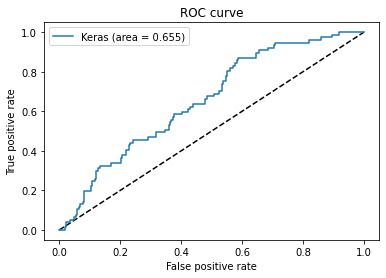

In [103]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [113]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [114]:
Find_Optimal_Cutoff(y_test, y_pred_keras)

[0.7086130976676941]

In [124]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_keras)
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

In [133]:
roc

,tf,threshold
0,-1.000000,1.986952
1,-0.995516,0.986952
2,-0.982063,0.981967
3,-0.969076,0.979444
4,-0.964591,0.978340
...,...,...
112,0.870887,0.266976
113,0.883874,0.262538
114,0.906295,0.221566
115,0.919283,0.195179


In [138]:
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,tf,threshold
65,0.00099,0.708613


In [119]:
np.median(thresholds_keras)

0.7394614

In [110]:
thresholds_keras

array([1.9869518 , 0.9869518 , 0.98196745, 0.979444  , 0.97834   ,
       0.9754702 , 0.97063845, 0.9690069 , 0.9679357 , 0.96452934,
       0.9633893 , 0.96217483, 0.9617704 , 0.95678073, 0.9552556 ,
       0.95426404, 0.9529816 , 0.9506919 , 0.94901395, 0.9472924 ,
       0.94622874, 0.93989843, 0.924806  , 0.9192951 , 0.9174981 ,
       0.9155852 , 0.91189504, 0.9036926 , 0.90263796, 0.89453924,
       0.89415693, 0.89262515, 0.88612425, 0.8842817 , 0.8632741 ,
       0.85975003, 0.84939843, 0.84882796, 0.8479073 , 0.845871  ,
       0.8424679 , 0.839988  , 0.83276737, 0.8307667 , 0.83010215,
       0.8197719 , 0.81805694, 0.8157035 , 0.79286337, 0.7855036 ,
       0.77427757, 0.7708956 , 0.7624886 , 0.7562036 , 0.74910337,
       0.74566865, 0.7423848 , 0.7410461 , 0.7394614 , 0.7364499 ,
       0.7341315 , 0.7313205 , 0.7302177 , 0.7300874 , 0.71544677,
       0.7086131 , 0.6839941 , 0.6822782 , 0.6765933 , 0.6763893 ,
       0.6678508 , 0.66777503, 0.6333585 , 0.6297868 , 0.62912

In [245]:
## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(fileimages)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

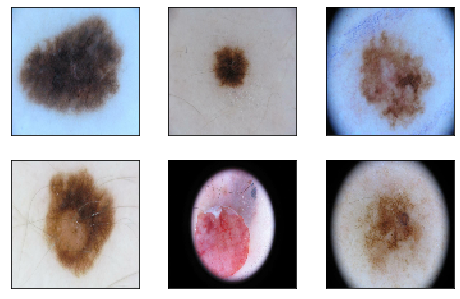

In [234]:
plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(6)):
    plt.subplot(3,3,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])